In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import seed
import tensorflow as tf
from tensorflow import set_random_seed
import sklearn
from sklearn import preprocessing
from sklearn import model_selection
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation,Flatten
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.python.keras import regularizers
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import backend
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import time
import math
from tensorflow.python.keras.layers import GRU,Masking,TimeDistributed,BatchNormalization
import sys
import tensorflow.python.keras.backend as K
from tensorflow.python.keras import Input, Model
from tensorflow.python.keras.layers.merge import concatenate, Average   
from tcn import TCN, tcn_full_summary
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
Columns = ["P_ID","5-1_value","5-2_value","5-3_value","2-1_M","2-3_M","3-1_M","5-1_M","5-3_M","TYPE"]
Dp = ['DATE','MASK_ID','SUBSTRATE_ID','SHUTTER','SRC3_SHUTTER_STATUS','EVAPORATION_HALT','TIME']
Label_Index = ['PLC_THICKNESS_SP','CRYSTAL_REMAINING_2','PLC_THICKNESS_1','CELL_CHANGE_CTRL_DLY_TIME_2','PLC_THICKNESS_2','THICKNESS_3','XXXX_POWER_3','PLC_THICKNESS_3']
TargetIndex = ["CIEX","CIEY","CIEX_DIFF","CIEY_DIFF"]

In [ ]:
train_df = pd.read_csv("data1/train.csv")
train_df.drop_duplicates(subset = ['P_ID'],inplace=True)
train_log_df = pd.read_csv("data1/train_log.csv")
test_df = pd.read_csv("data1/test.csv")
test_log_df = pd.read_csv("data1/test_log.csv")
all_df = pd.concat([train_df,test_df])
all_log_df = pd.concat([train_log_df,test_log_df])
all_log_df = all_log_df.interpolate()
Data_df = all_df[Columns]

In [ ]:
L = len(train_df)
OneHotData_df = pd.get_dummies(Data_df)
Std = ["5-1_value","5-2_value","5-3_value"]
OneHotData_df[Std] = pd.DataFrame(preprocessing.scale(OneHotData_df[Std]))
train = OneHotData_df[:L]
train = train.dropna()
sub_label = OneHotData_df[L:]
train_label, test_label, train_feature, test_feature =  model_selection.train_test_split( train,all_df[TargetIndex][:L], test_size=0.33, random_state=42)
train_label = train_label[:L]
sc = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(train_feature)
train_feature = pd.DataFrame(sc.transform(train_feature))
train_feature = train_feature[:L]

In [88]:
# LOG = []
# n=300
# for i in test_df['P_ID']:
#     C = all_log_df[all_log_df['P_ID']==i].sort_values('TIME')[Label_Index]
#     LOG.append(np.array(preprocessing.scale(C)))
#     sys.stdout.write("\r Now Loading : %d " %(i))
#     sys.stdout.flush()
# sub_log = np.array(LOG)
LOG = []
n=300
for i in train_label['P_ID']:
    C = all_log_df[all_log_df['P_ID']==i].sort_values('TIME')[Label_Index]
    LOG.append(np.array(preprocessing.scale(C)))
    #     LOG.append(np.array(C.drop(Dp,axis=1)[:41]))
    sys.stdout.write("\r Now Loading : %d " %(i))
    sys.stdout.flush()
train_log = np.array(LOG)
LOG = []
n=300
for i in test_label['P_ID']:
    C = all_log_df[all_log_df['P_ID']==i].sort_values('TIME')[Label_Index]
    LOG.append(np.array(preprocessing.scale(C)))
    sys.stdout.write("\r Now Loading : %d " %(i))
    sys.stdout.flush()
test_log = np.array(LOG)

 Now Loading : 6339825 

In [90]:
sub_log.shape

(5723,)

In [ ]:
all_log_df = pd.concat([train_log_df,test_log_df])
all_log_df = all_log_df.interpolate()
all_log_df[Label_Index] = pd.DataFrame(preprocessing.scale(all_log_df[Label_Index]))
LOG = []
Len = 414
n=300
for i in train_label['P_ID']:
    C = all_log_df[all_log_df['P_ID']==i].sort_values('TIME')[Label_Index]
    X = []
    if len(C)>Len:
        n = int(len(C)/Len)
        for j in range(Len):
            X.append(np.mean(C[j*n:(j+1)*n]))
    else:
        for j in range(Len):
            if j < len(C):
                X.append(C.iloc[j])
            else:
                X.append(np.zeros(8))
    LOG.append(np.array(X))
    sys.stdout.write("\r Now Loading : %d " %(i))
    sys.stdout.flush()
train_log = np.array(LOG)

LOG = []
Len = 414
n=300
for i in test_label['P_ID']:
    C = all_log_df[all_log_df['P_ID']==i].sort_values('TIME')[Label_Index]
    X = []
    if len(C)>Len:
        n = int(len(C)/Len)
        for j in range(Len):
            X.append(np.mean(C[j*n:(j+1)*n]))
    else:
        for j in range(Len):
            if j < len(C):
                X.append(C.iloc[j])
            else:
                X.append(np.zeros(8))
    LOG.append(np.array(X))
    sys.stdout.write("\r Now Loading : %d " %(i))
    sys.stdout.flush()
test_log = np.array(LOG)

LOG = []
Len = 414
n=300
for i in test_df['P_ID']:
    C = all_log_df[all_log_df['P_ID']==i].sort_values('TIME')[Label_Index]
    X = []
    if len(C)>Len:
        n = int(len(C)/Len)
        for j in range(Len):
            X.append(np.mean(C[j*n:(j+1)*n]))
    else:
        for j in range(Len):
            if j < len(C):
                X.append(C.iloc[j])
            else:
                X.append(np.zeros(8))
    LOG.append(np.array(X))
    sys.stdout.write("\r Now Loading : %d " %(i))
    sys.stdout.flush()
sub_log = np.array(LOG)

In [ ]:
LOG = []
n=300
for i in test_df['P_ID']:
    C = all_log_df[all_log_df['P_ID']==i].sort_values('TIME')[Label_Index]
    X = []
    n = int(len(C)/40)
    for j in range(40):
        X.append(np.mean(C[j*n:(j+1)*n]))
    LOG.append(np.array(preprocessing.scale(X)))
    sys.stdout.write("\r Now Loading : %d " %(i))
    sys.stdout.flush()
sub_log = np.array(LOG)
LOG = []
n=300
for i in train_label['P_ID']:
    C = all_log_df[all_log_df['P_ID']==i].sort_values('TIME')[Label_Index]
    X = []
    n = int(len(C)/40)
    for j in range(40):
        X.append(np.mean(C[j*n:(j+1)*n]))
    LOG.append(np.array(preprocessing.scale(X)))
    #     LOG.append(np.array(C.drop(Dp,axis=1)[:41]))
    sys.stdout.write("\r Now Loading : %d " %(i))
    sys.stdout.flush()
train_log = np.array(LOG)
LOG = []
n=300
for i in test_label['P_ID']:
    C = all_log_df[all_log_df['P_ID']==i].sort_values('TIME')[Label_Index]
    X = []
    n = int(len(C)/40)
    for j in range(40):
        X.append(np.mean(C[j*n:(j+1)*n]))
    LOG.append(np.array(preprocessing.scale(X)))
    sys.stdout.write("\r Now Loading : %d " %(i))
    sys.stdout.flush()
test_log = np.array(LOG)

In [ ]:
LOG = []
n=300
for i in test_df['P_ID']:
    C = all_log_df[all_log_df['P_ID']==i].sort_values('TIME').drop(Dp,axis=1)
    X = []
    n = int(len(C)/40)
    for j in range(40):
        X.append(np.mean(C[j*n:(j+1)*n]))
    LOG.append(np.array(preprocessing.scale(X)))
    sys.stdout.write("\r Now Loading : %d " %(i))
    sys.stdout.flush()
sub_log = np.array(LOG)
LOG = []
n=300
for i in train_label['P_ID']:
    C = all_log_df[all_log_df['P_ID']==i].sort_values('TIME').drop(Dp,axis=1)
    X = []
    n = int(len(C)/40)
    for j in range(40):
        X.append(np.mean(C[j*n:(j+1)*n]))
    LOG.append(np.array(preprocessing.scale(X)))
    #     LOG.append(np.array(C.drop(Dp,axis=1)[:41]))
    sys.stdout.write("\r Now Loading : %d " %(i))
    sys.stdout.flush()
train_log = np.array(LOG)
LOG = []
n=300
for i in test_label['P_ID']:
    C = all_log_df[all_log_df['P_ID']==i].sort_values('TIME').drop(Dp,axis=1)
    X = []
    n = int(len(C)/40)
    for j in range(40):
        X.append(np.mean(C[j*n:(j+1)*n]))
    LOG.append(np.array(preprocessing.scale(X)))
    sys.stdout.write("\r Now Loading : %d " %(i))
    sys.stdout.flush()
test_log = np.array(LOG)

In [77]:
def my_mean_absolute_error(y_true, y_pred):
    W = [0.249,0.330,0.172,0.204]
#     print(y_pred*W)
    return K.sum(K.abs((y_pred - y_true)*W))
# , axis=-1

In [109]:
train_log.shape

(3318,)

In [111]:
backend.clear_session()
# tf.random.set_seed(3)

set_random_seed(2)
# checkpointer = ModelCheckpoint(filepath='Model/TCN_ZIPTEST.hdf5',monitor='loss', verbose=1, save_best_only=True)
my_adam = optimizers.adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

X_MLP = Input(shape=(35))
X_TS = Input(batch_shape=(None,None,8))

MLP_Layer = Dense(128,kernel_initializer='uniform',activation='relu')(X_MLP)
MLP_Layer = Dense(32,kernel_initializer='uniform',activation='relu')(MLP_Layer)
TCN_Layer = TCN(nb_filters=128, kernel_size=2, nb_stacks=1, dilations=[1, 2, 4, 8, 16, 32], padding='causal', use_skip_connections=True, dropout_rate=0., return_sequences=True, activation='relu', kernel_initializer='he_normal', use_batch_norm=False)(X_TS)
TCN_Layer = TCN(nb_filters=4,return_sequences=False,kernel_initializer='he_normal')(TCN_Layer)
# GRU_Layer = GRU(128,return_sequences=True)(X_TS)
# GRU_Layer = GRU(32,return_sequences=False)(GRU_Layer)

Merge = concatenate([MLP_Layer, TCN_Layer])
Merge = Dense(128, activation='relu',kernel_initializer='uniform',)(Merge)


Y = Dense(4, activation='sigmoid',kernel_initializer='uniform')(Merge)

Model_Hybrid = Model(inputs=[X_MLP,X_TS] ,outputs = Y)
Model_Hybrid.compile(loss=my_mean_absolute_error, optimizer=my_adam)



In [113]:
# hist = Model_Hybrid.fit([train_label.drop(['P_ID'],axis=1),train_log], train_feature, batch_size=128,epochs=1000 , verbose=1,validation_split=0,callbacks=[checkpointer])
set_random_seed(2)
hist = Model_Hybrid.fit([train_label.drop(['P_ID'],axis=1),train_log], train_feature, batch_size=128,epochs=1000 , verbose=1,validation_split=0)

ValueError: Error when checking input: expected input_2 to have 3 dimensions, but got array with shape (3318, 1)

In [84]:
test_1_Pre =  Model_Hybrid.predict([test_label.drop(['P_ID'],axis=1),test_log])
Pre_df = pd.DataFrame(test_1_Pre)
Pre_df = pd.DataFrame(sc.inverse_transform(Pre_df))
W = [0.249,0.330,0.172,0.204]
Wmae = 0
for n in range(4):
    MAE = 0
    for i in range(len(Pre_df[0])):
        MAE = MAE + abs(Pre_df[n][i]-test_feature[TargetIndex[n]].iloc[i])
#     print(MAE/len(Pre_df[n]))
    Wmae = Wmae + (MAE/len(Pre_df[n]))*W[n]
print(Wmae)

0.005740639752027373


In [ ]:
# Model_Hybrid.load_weights("Model/weights.hdf5")
test_1_Pre =  Model_Hybrid.predict([test_label.drop(['P_ID'],axis=1),test_log])
Pre_df = pd.DataFrame(test_1_Pre)
Pre_df = pd.DataFrame(sc.inverse_transform(Pre_df))
W = [0.249,0.330,0.172,0.204]
Wmae = 0
for n in range(4):
    MAE = 0
    for i in range(len(Pre_df[0])):
        MAE = MAE + abs(Pre_df[n][i]-test_feature[TargetIndex[n]].iloc[i])
#     print(MAE/len(Pre_df[n]))
    Wmae = Wmae + (MAE/len(Pre_df[n]))*W[n]
print(Wmae)

In [ ]:
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.legend()
plt.savefig('ZIP_GRU_loss.jpg',bbox_inches = 'tight')

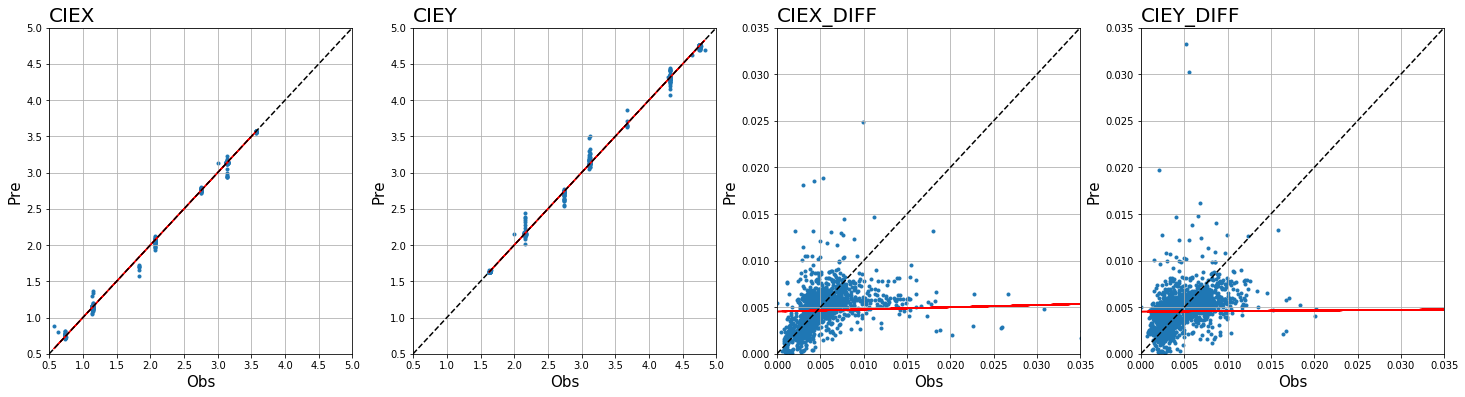

In [85]:
from sklearn.metrics import r2_score
plt.figure(figsize=(25,6))
for n in range(2):
    plt.subplot(1,4,n+1)
    plt.scatter(test_feature[TargetIndex[n]],Pre_df[n],marker = ".")
    plt.title(test_feature.columns[n],loc='left',fontsize=20)
    plt.xlabel("Obs",fontsize=15)
    plt.ylabel("Pre",fontsize=15)
    plt.ylim(0.5,5)
    plt.xlim(0.5,5)
    z = np.polyfit(pd.to_numeric(test_feature[TargetIndex[n]]), pd.to_numeric(Pre_df[n]), 1)
    p = np.poly1d(z) 
    plt.plot(test_feature[TargetIndex[n]],p(test_feature[TargetIndex[n]]),"r")
    plt.grid()
    plt.plot([0.5, 5], [0.5, 5],ls='--',c="0")
for n in range(2,4,1):
    plt.subplot(1,4,n+1)
    plt.scatter(test_feature[TargetIndex[n]],Pre_df[n],marker = ".")
    plt.title(test_feature.columns[n],loc='left',fontsize=20)
    plt.xlabel("Obs",fontsize=15)
    plt.ylabel("Pre",fontsize=15)
    plt.ylim(0,0.035)
    plt.xlim(0,0.035)
    z = np.polyfit(pd.to_numeric(test_feature[TargetIndex[n]]), pd.to_numeric(Pre_df[n]), 1)
    p = np.poly1d(z)
    plt.plot(test_feature[TargetIndex[n]],p(test_feature[TargetIndex[n]]),"r")
    plt.grid()
    plt.plot([0, 0.035], [0, 0.035],ls='--',c="0")
# plt.savefig('MAE.jpg',bbox_inches='tight')

In [ ]:
sub_1_Pre =  Model_Hybrid.predict([sub_label.drop(['P_ID'],axis=1),sub_log])
Pre_df = pd.DataFrame(sub_1_Pre)
Pre_df = pd.DataFrame(sc.inverse_transform(Pre_df))

In [ ]:
writer = pd.ExcelWriter('subdnnreport.xlsx')
Pre_df.to_excel(writer,sheet_name="1")
writer.save()